# Script to plot location of Cu-on-Zn or Zn-on-Cu antisites
Plot adapted from script to generate 3D scatter plot to 2D Cu-Zn layers.

First 3 scripts generate files containing coordinates of antisites (make sure to have a directory called 'antisite_data' for these to be stored in and that gulp input files are in a directory called 'GULP_inputs').

The script below then sorts these files according to z values and allows the user to generate 2D scatter plots of antisite locations for particular z-values.

## Horrendous old script to modify (or just use to generate .txt files for antisite locations for 3D data for each T and post-process after?)

Need to add T range and system dimensions to top of script and run all 3 cells.

In [1]:
%%bash
mkdir antisite_data

mkdir: antisite_data: File exists


In [2]:
############################## USER INPUTS #########################################

# Name of gulp input files (not including temperature - check outputs for format in latest version of code)
filename_start = "T_"
filename_end = "_gulp_final_lattice.in"
# Temperature range and step size from Eris simulation
TMIN = 0
TMAX = 1000
TSTEP = 50
# Enter dimensions of lattice
X_dim = 32
Y_dim = 32
Z_dim = 32

In [3]:
# Generating list containing input and output filenames for lattice configurations at each simulation T
input_files=[]
#Q_param_files=[]
#site_occ_files=[]
Cu_on_Zn_files=[]
Zn_on_Cu_files=[]
Sn_on_Cu_files=[]
Sn_on_Zn_files=[]
Cu_on_Sn_files=[]
Zn_on_Sn_files=[]
#disorder_sites_files=[]
error_files=[]
order_files=[]
for T in range (TMIN, TMAX+TSTEP, TSTEP):
    T_formatted= str(T).zfill(4)
    input_files.append(str(filename_start)+str(T_formatted)+str(filename_end))
#    Q_param_files.append("Q_data/Q_parameter_T_"+str(T_formatted)+".txt")
#    site_occ_files.append("Q_data/site_occupancies_T_"+str(T_formatted)+".txt")
    Cu_on_Zn_files.append("antisite_data/Cu_on_Zn_coords_T_"+str(T_formatted)+".txt")
    Zn_on_Cu_files.append("antisite_data/Zn_on_Cu_coords_T_"+str(T_formatted)+".txt")
    Sn_on_Cu_files.append("antisite_data/Sn_on_Cu_coords_T_"+str(T_formatted)+".txt")
    Sn_on_Zn_files.append("antisite_data/Sn_on_Zn_coords_T_"+str(T_formatted)+".txt")
    Cu_on_Sn_files.append("antisite_data/Cu_on_Sn_coords_T_"+str(T_formatted)+".txt")
    Zn_on_Sn_files.append("antisite_data/Zn_on_Sn_coords_T_"+str(T_formatted)+".txt")
#    disorder_sites_files.append("Q_data/disordered_sites_T_"+str(T_formatted)+".txt")
    error_files.append("antisite_data/error_log_T_"+str(T_formatted)+".txt")
    order_files.append("antisite_data/order_log_T_"+str(T_formatted)+".txt")

print(input_files)

['T_0000_gulp_final_lattice.in', 'T_0050_gulp_final_lattice.in', 'T_0100_gulp_final_lattice.in', 'T_0150_gulp_final_lattice.in', 'T_0200_gulp_final_lattice.in', 'T_0250_gulp_final_lattice.in', 'T_0300_gulp_final_lattice.in', 'T_0350_gulp_final_lattice.in', 'T_0400_gulp_final_lattice.in', 'T_0450_gulp_final_lattice.in', 'T_0500_gulp_final_lattice.in', 'T_0550_gulp_final_lattice.in', 'T_0600_gulp_final_lattice.in', 'T_0650_gulp_final_lattice.in', 'T_0700_gulp_final_lattice.in', 'T_0750_gulp_final_lattice.in', 'T_0800_gulp_final_lattice.in', 'T_0850_gulp_final_lattice.in', 'T_0900_gulp_final_lattice.in', 'T_0950_gulp_final_lattice.in', 'T_1000_gulp_final_lattice.in']


In [4]:
### Generating antisite location files

import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from IPython.core.pylabtools import figsize
#figsize(10, 10)

# Defining temperature list from user input and initialising empty list to write Q as a function of T to
T = np.arange(TMIN, TMAX+TSTEP, TSTEP)
#Q_vs_T =[]

# Defining row number where cation coords start and end based on supercell dimensions
cation_coord_start = 9+8*(X_dim//2)*(Y_dim//2)*(Z_dim//4)  # Skipping over S ions (9 lines of text, 8 S ions per 2x2x4 unit)
cation_coord_end = cation_coord_start+(X_dim*Y_dim*Z_dim)//2    # half of initial lattice contained gap sites which are not written to gulp input file

# Halving Z lattice dimension because half of initial lattice sites are empty, which are not written to the gulp input (see lattice initialisation method2 in eris-lattice.c)
Z=Z_dim//2  # /2 because gap sites from lattice[x][y][z] not written to gulp input
X=X_dim
Y=Y_dim

# Reading in data files and calculating Q for each T
for i in range (0, len(T)):
    
#    print("Calculating Q for T = "+str(T[i])+" K lattice configuration")
    
    # Reading in gulp input file and storing as a matrix where data[row from zero][col from zero]
    data = pd.read_csv(input_files[i], names =["species", "core", "x", "y", "z", "charge"], delimiter=" ").as_matrix()
    # Initialising empty lists for occupancy of 2a, 2b, 2c and 2d sites + a list containing coordinates (full gulp input row) for disordered sites
#    a=[]
#    b=[]
#    c=[]
#    d=[]
    disordered=[]
    order_log=[]
    error_log=[]
#    Cu_2c=0
#    Zn_2d=0
#    Cu_2d=0
#    Zn_2c=0

# x,y,z coords for all cation antisites
    Cu_on_Zn_x=[]
    Cu_on_Zn_y=[]
    Cu_on_Zn_z=[]
    Zn_on_Cu_x=[]
    Zn_on_Cu_y=[]
    Zn_on_Cu_z=[]
    Sn_on_Zn_x=[]
    Sn_on_Zn_y=[]
    Sn_on_Zn_z=[]
    Sn_on_Cu_x=[]
    Sn_on_Cu_y=[]
    Sn_on_Cu_z=[]
    Cu_on_Sn_x=[]
    Cu_on_Sn_y=[]
    Cu_on_Sn_z=[]
    Zn_on_Sn_x=[]
    Zn_on_Sn_y=[]
    Zn_on_Sn_z=[]
    
    # Opening files to write to
#    Q_param_file=open(Q_param_files[i],'w')
#    occupancies_file=open(site_occ_files[i],'w')
    Cu_on_Zn_coords=open(Cu_on_Zn_files[i],'w')
    Zn_on_Cu_coords=open(Zn_on_Cu_files[i],'w')
    Sn_on_Cu_coords=open(Sn_on_Cu_files[i],'w')
    Sn_on_Zn_coords=open(Sn_on_Zn_files[i],'w')
    Cu_on_Sn_coords=open(Cu_on_Zn_files[i],'w')
    Zn_on_Sn_coords=open(Zn_on_Sn_files[i],'w')
#    disorder_file=open(disorder_sites_files[i], 'w')
    error_log_file=open(error_files[i], 'w')
    order_log_file=open(order_files[i], 'w')
    
    # ----- Begin calculation of Q parameter -------------------------------------
    # Initialising number of rows contained within each x-loop iteration
    x_block=0

    for x in range(0, X):
        for y in range(0, Y):
            # --------------------- even x,y -----------------------------------------------
            if ( math.fmod(x, 2) == 0 and math.fmod(y, 2) == 0 ):
                # Looping over list of z (repeats every 2 species)
                for z in range(cation_coord_start, Z+cation_coord_start, 2):
                    
                    # Writing species to 2b site file
 #                   b.append(data[z + (y*Z) + x_block][0])
                    # Checking if first of two repeating species for even x, even y list is correct
                    if data[z + (y*Z) + x_block][0] == "Sn":    ### 2b site
                        order_log.append("yes! - Sn is Sn")
                    else: 
                        error_log.append("uh oh! Sn error! -- "+str(data[z + (y*Z) + x_block][0]))
                        print("Looks like there's some Sn disorder! Has Sn been unfrozen?")
                        disordered.append(str(data[z + (y*Z) + x_block][:]))
                        if data[z + (y*Z) + x_block][0] == "Cu":
                            Cu_on_Sn_x.append(data[z + (y*Z) + x_block][2])
                            Cu_on_Sn_y.append(data[z + (y*Z) + x_block][3])
                            Cu_on_Sn_z.append(data[z + (y*Z) + x_block][4])
                        if data[z + (y*Z) + x_block][0] == "Zn":
                            Zn_on_Sn_x.append(data[z + (y*Z) + x_block][2])
                            Zn_on_Sn_y.append(data[z + (y*Z) + x_block][3])
                            Zn_on_Sn_z.append(data[z + (y*Z) + x_block][4])
   
                    # Writing species to 2a site file
#                    a.append(data[z+1 + (y*Z) + x_block][0])
                    # Checking if second of two repeating species for even x, even y list is correct
                    if data[z+1 + (y*Z) + x_block][0] == "Cu":    ### 2a site
                        order_log.append("yes! - Cu is Cu")
                    else:
                        error_log.append("uh oh! Cu error! -- "+str(data[z+1 + (y*Z) + x_block][0]))
                        print("Cu is not on the 2a site - are you simulating 3D Cu-Zn disorder?")
                        disordered.append(str(data[z+1 + (y*Z) + x_block][:]))
                        if data[z+1 + (y*Z) + x_block][0] == "Zn":
                            Zn_on_Cu_x.append(data[z+1 + (y*Z) + x_block][2])
                            Zn_on_Cu_y.append(data[z+1 + (y*Z) + x_block][3])
                            Zn_on_Cu_z.append(data[z+1 + (y*Z) + x_block][4])
                        if data[z+1 + (y*Z) + x_block][0] == "Sn":
                            Sn_on_Cu_x.append(data[z+1 + (y*Z) + x_block][2])
                            Sn_on_Cu_y.append(data[z+1 + (y*Z) + x_block][3])
                            Sn_on_Cu_z.append(data[z+1 + (y*Z) + x_block][4])
 
            # ------------------ even x, odd y --------------------------------------------
            elif ( math.fmod(x, 2) == 0 and math.fmod(y, 2) != 0 ):
                # Loop over list of length Z
                for z in range(cation_coord_start, Z+cation_coord_start, 2):
                    
                    # Writing species to 2d site file
#                    d.append(data[z + (y*Z) + x_block][0])
                    if data[z + (y*Z) + x_block][0] == "Zn":   ### 2d site
                        order_log.append("yes! - Zn is Zn!")
#                        Zn_2d += 1
                    else:
#                        error_log.append("uh oh! Zn error! -- "+str(data[z + (y*Z) + x_block][0]))
                        disordered.append(str(data[z + (y*Z) + x_block][:]))
                        if data[z + (y*Z) + x_block][0] == "Cu":
                            Cu_on_Zn_x.append(data[z + (y*Z) + x_block][2])
                            Cu_on_Zn_y.append(data[z + (y*Z) + x_block][3])
                            Cu_on_Zn_z.append(data[z + (y*Z) + x_block][4])
                        if data[z + (y*Z) + x_block][0] == "Sn":
                            Sn_on_Zn_x.append(data[z + (y*Z) + x_block][2])
                            Sn_on_Zn_y.append(data[z + (y*Z) + x_block][3])
                            Sn_on_Zn_z.append(data[z + (y*Z) + x_block][4])

                    # Writing species to 2c site file
 #                   c.append(data[z+1 + (y*Z) + x_block][0])
                    if data[z+1 + (y*Z) + x_block][0] == "Cu":   ### 2c site
                        order_log.append("yes! - Cu is Cu again")
 #                       Cu_2c += 1
                    else:
 #                       error_log.append("uh oh! error for 2c Cu -- "+str(data[z+1 + (y*Z) + x_block][0]))
                        disordered.append(str(data[z+1 + (y*Z) + x_block][:]))
                        if data[z+1 + (y*Z) + x_block][0] == "Zn":
 #                           Zn_2c += 1
                            Zn_on_Cu_x.append(data[z+1 + (y*Z) + x_block][2])
                            Zn_on_Cu_y.append(data[z+1 + (y*Z) + x_block][3])
                            Zn_on_Cu_z.append(data[z+1 + (y*Z) + x_block][4])
                        if data[z+1 + (y*Z) + x_block][0] == "Sn":
                            Sn_on_Cu_x.append(data[z+1 + (y*Z) + x_block][2])
                            Sn_on_Cu_y.append(data[z+1 + (y*Z) + x_block][3])
                            Sn_on_Cu_z.append(data[z+1 + (y*Z) + x_block][4])

            # --------------------- odd x,even y -----------------------------------------------
            if ( math.fmod(x, 2) != 0 and math.fmod(y, 2) == 0 ):
  
                # Looping over list of z (repeats every 2 species)
                for z in range(cation_coord_start, Z+cation_coord_start, 2):
  
                    # Writing species to 2c site file
  #                  c.append(data[z + (y*Z) + x_block][0])
                    # Checking if first of two repeating species for even x, even y list is correct
                    if data[z + (y*Z) + x_block][0] == "Cu":    ### 2c site
                        order_log.append("yes! - Cu is Cu again")
  #                      Cu_2c += 1
                    else:
                        error_log.append("Cu 2c disorder (okay if this is Zn) -- "+str(data[z + (y*Z) + x_block][0]))
                        disordered.append(str(data[z + (y*Z) + x_block][:]))
                    if data[z + (y*Z) + x_block][0] == "Zn":
  #                      Zn_2c += 1
                        Zn_on_Cu_x.append(data[z + (y*Z) + x_block][2])
                        Zn_on_Cu_y.append(data[z + (y*Z) + x_block][3])
                        Zn_on_Cu_z.append(data[z + (y*Z) + x_block][4])
                    if data[z + (y*Z) + x_block][0] == "Sn":
                        Sn_on_Cu_x.append(data[z + (y*Z) + x_block][2])
                        Sn_on_Cu_y.append(data[z + (y*Z) + x_block][3])
                        Sn_on_Cu_z.append(data[z + (y*Z) + x_block][4])
         
                    # Writing species to 2d site file
  #                  d.append(data[z+1 + (y*Z) + x_block][0]) 
                    # Checking if second of two repeating species for even x, even y list is correct
                    if data[z+1 + (y*Z) + x_block][0] == "Zn":    ### 2d site
                        order_log.append("yes! - Zn is Zn")
  #                      Zn_2d += 1
                    else:
                        error_log.append("Zn disorder (okay if this is Cu) -- "+str(data[z+1 + (y*Z) + x_block][0]))
                        disordered.append(str(data[z+1 + (y*Z) + x_block][:]))
                    if data[z+1 + (y*Z) + x_block][0] == "Cu":
#                        Cu_2d += 1   
                        Cu_on_Zn_x.append(data[z+1 + (y*Z) + x_block][2])
                        Cu_on_Zn_y.append(data[z+1 + (y*Z) + x_block][3])
                        Cu_on_Zn_z.append(data[z+1 + (y*Z) + x_block][4])
                    if data[z+1 + (y*Z) + x_block][0] == "Sn":
                        Sn_on_Zn_x.append(data[z+1 + (y*Z) + x_block][2])
                        Sn_on_Zn_y.append(data[z+1 + (y*Z) + x_block][3])
                        Sn_on_Zn_z.append(data[z+1 + (y*Z) + x_block][4])

            # ------------------ odd x,y -----------------------------------------------------
            elif ( math.fmod(x, 2) != 0 and math.fmod(y, 2) != 0 ):

                # Loop over list of length Z
                for z in range(cation_coord_start, Z+cation_coord_start, 2):
    
                    # Writing species to 2a site file
 #                   a.append(data[z + (y*Z) + x_block][0])
                    if data[z + (y*Z) + x_block][0] == "Cu":     ### 2a site
                        order_log.append("yes! - Cu is Cu!")
                    else:
                        error_log.append("uh oh! Cu error! --  "+str(data[z + (y*Z) + x_block][0]))
                        print("Cu is not on the 2a site - are you simulating 3D Cu-Zn disorder?")
                        disordered.append(str(data[z + (y*Z) + x_block][:]))
                        if data[z + (y*Z) + x_block][0] == "Zn":
                            Zn_on_Cu_x.append(data[z + (y*Z) + x_block][2])
                            Zn_on_Cu_y.append(data[z + (y*Z) + x_block][3])
                            Zn_on_Cu_z.append(data[z + (y*Z) + x_block][4])
                        if data[z + (y*Z) + x_block][0] == "Sn":
                            Sn_on_Cu_x.append(data[z + (y*Z) + x_block][2])
                            Sn_on_Cu_y.append(data[z + (y*Z) + x_block][3])
                            Sn_on_Cu_z.append(data[z + (y*Z) + x_block][4])

                    # Writing species to 2b site file
 #                   b.append(data[z+1 + (y*Z) + x_block][0])
                    if data[z+1 + (y*Z) + x_block][0] == "Sn":    ### 2b site
                        order_log.append("yes! - Sn is Sn")
                    else:
                        error_log.append("uh oh! error for Sn --  "+str(data[z+1 + (y*Z) + x_block][0]))
                        print("Looks like there's some Sn disorder! Has Sn been unfrozen?")
                        disordered.append(str(data[z+1 + (y*Z) + x_block][:]))
                        if data[z+1 + (y*Z) + x_block][0] == "Cu":
                            Cu_on_Sn_x.append(data[z+1 + (y*Z) + x_block][2])
                            Cu_on_Sn_y.append(data[z+1 + (y*Z) + x_block][3])
                            Cu_on_Sn_z.append(data[z+1 + (y*Z) + x_block][4])
                        if data[z+1 + (y*Z) + x_block][0] == "Zn":
                            Zn_on_Sn_x.append(data[z+1 + (y*Z) + x_block][2])
                            Zn_on_Sn_y.append(data[z+1 + (y*Z) + x_block][3])
                            Zn_on_Sn_z.append(data[z+1 + (y*Z) + x_block][4])

            # --------------------------------------------------------------------------------

        # Updating number of rows already checked from previous x-loop iteration
        x_block += Y*Z


    # ------------------------------------------------------------------------------------
    # Writing lists to output files

    for j in order_log:
        order_log_file.write(j+'\n')
    for j in error_log:
        error_log_file.write(j+'\n') 

#    df = pd.DataFrame({'# 2a' : a, '2b' : b, '2c' : c, '2d' : d})
#    df.to_csv(occupancies_file, sep='\t')
    
    # Writing antisite coordinates to separate files (Cu-Zn disorder)
    df = pd.DataFrame({'# x' : Cu_on_Zn_x, 'y' : Cu_on_Zn_y, 'z' : Cu_on_Zn_z})
    df.to_csv(Cu_on_Zn_coords, sep='\t')
    df = pd.DataFrame({'# x' : Zn_on_Cu_x, 'y' : Zn_on_Cu_y, 'z' : Zn_on_Cu_z})
    df.to_csv(Zn_on_Cu_coords, sep='\t')
    
    df = pd.DataFrame({'# x' : Cu_on_Sn_x, 'y' : Cu_on_Sn_y, 'z' : Cu_on_Sn_z})
    df.to_csv(Cu_on_Sn_coords, sep='\t')
    df = pd.DataFrame({'# x' : Zn_on_Sn_x, 'y' : Zn_on_Sn_y, 'z' : Zn_on_Sn_z})
    df.to_csv(Zn_on_Sn_coords, sep='\t')
    df = pd.DataFrame({'# x' : Sn_on_Zn_x, 'y' : Sn_on_Zn_y, 'z' : Sn_on_Zn_z})
    df.to_csv(Sn_on_Zn_coords, sep='\t')
    df = pd.DataFrame({'# x' : Sn_on_Cu_x, 'y' : Sn_on_Cu_y, 'z' : Sn_on_Cu_z})
    df.to_csv(Sn_on_Cu_coords, sep='\t')
    
    
    
#    for i in disordered:
#        disorder_file.write(i+'\n')

    # Calculating Q parameter
#    Q = float( (Cu_2c + Zn_2d) - (Zn_2c + Cu_2d) ) / ( (Cu_2c + Zn_2d) + (Zn_2c + Cu_2d) )

#    Q_param_file.write('# Q ='+str(Q)+'\n')
#    Q_param_file.write('# Where Q = [ (Cu-on-2c + Zn-on-2d) - (Zn-on-2c + Cu-on-2d) ] / [ (Cu-on-2c + Zn-on-2d) + (Zn-on-2c + Cu-on-2d) ]'+'\n')
#    Q_param_file.write('# Q=1 corresponds to perfect order, Q=0 is complete disorder where Cu and Zn (within the Cu-Zn plane only) show no preference for their correct crystallographic site'+'\n')
#    Q_param_file.write('# Where Cu is on the 2c site and Zn on the 2d site in ordered CZTS'+'\n')
#    Q_param_file.write('# Cu_2c Zn_2d Cu_2d Zn_2c'+'\n')  
#    Q_param_file.write(str(Cu_2c)+'   '+str(Zn_2d)+'   '+str(Cu_2d)+'   '+str(Zn_2c))

    order_log_file.close()
    error_log_file.close()
#    disorder_file.close()
#    occupancies_file.close()
#    Q_param_file.close()
    Cu_on_Zn_coords.close()
    Zn_on_Cu_coords.close()
    Cu_on_Sn_coords.close()
    Zn_on_Sn_coords.close()
    Sn_on_Zn_coords.close()
    Sn_on_Cu_coords.close()
 

   ### Old way of plotting scatter plot
    
    # Writing Q to file to plot in ipython notebook
   # Q_vs_T.append(Q)

#    if T[i] == 600:
    
        ### Generating 3D scatter plots of antisite locations for given T
#        fig = plt.figure()
      #  ax = fig.add_subplot(111, projection='3d'))
#        ax = fig.add_subplot(111)
        
     #   print(Cu_on_Zn_y)

#        ax.scatter(Cu_on_Zn_x, Cu_on_Zn_y, c='r', marker='o', label="Cu-on-Zn defects")
#        ax.scatter(Zn_on_Cu_x, Zn_on_Cu_y, c='b', marker='^', label="Zn-on-Cu defects")

        
#        ax.set_xlabel('x (lattice units)')
#        ax.set_ylabel('y (lattice units)')
#
#        plt.xlim(0,35)
  #      plt.ylim(0,96)
  #      plt.zlim(0,96)
 #       ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#        plt.legend()
 #       plt.savefig('3D_scatter_test.png')
#        plt.show()


## Generate 2D antisite location scatter plots for specific z-slices

z-slices with Cu-Zn antisites are: [3, 7, 11, 15, 19, 23, 27, 31]


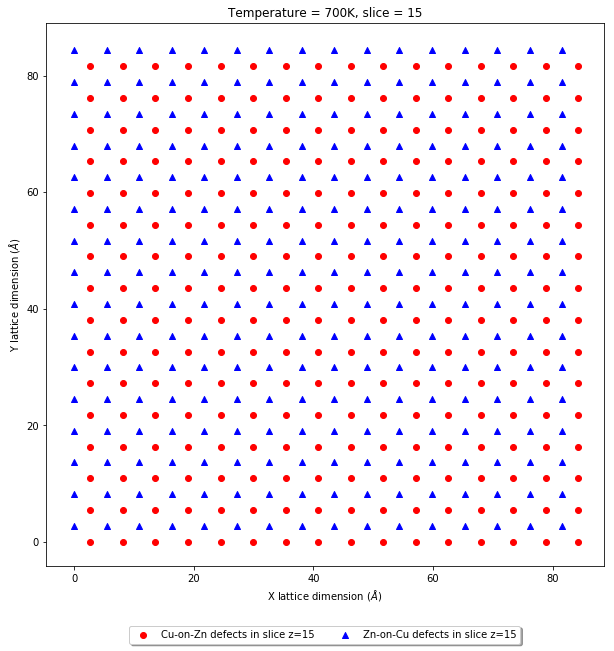

In [28]:
# New way of plotting scatter plot using antisite_data .txt files and plotting just for set z-value

figsize(10, 10)

### USER INPUTS #################################################
# Choose T and slice number to plot for
temp = 700
z_slice_plot = 15  # Ensure this is an odd number for Cu-Zn planes and less than max z-lattice dim
################################################################

temp_formatted= str(temp).zfill(4)

Cu_on_Zn_coord_file = pd.read_csv("antisite_data/Cu_on_Zn_coords_T_"+str(temp_formatted)+".txt", skiprows=1, delimiter='\t').as_matrix()
Zn_on_Cu_coord_file = pd.read_csv("antisite_data/Zn_on_Cu_coords_T_"+str(temp_formatted)+".txt", skiprows=1, delimiter='\t').as_matrix()
df = pd.DataFrame(Cu_on_Zn_coord_file)
df2 = pd.DataFrame(Zn_on_Cu_coord_file)
antisite_slices = []

# In dataframe, col1 =x, col2 =y, col3 = z (0 is line number unfortunately!)
# Order is [columns][rows]
# Sort by z-coordinate
df_sorted = df.sort_values(by=[3]).reset_index(drop=True) # Cu-on-Zn z-coord sorted antisite locations
#print(df_sorted)
df2_sorted = df2.sort_values(by=[3]).reset_index(drop=True) # Zn-on-Cu z-coord sorted antisite locations

# Getting coords for Cu-on-Zn antisites for simulation T and z_slice requested by user
# Initialise empty lists for slice coords
Cu_on_Zn_slice_x = []
Cu_on_Zn_slice_y = []
# Initialise z values to compare against in loop
z_val = df_sorted[3][0]
z_slice = int(round(z_val/2.72)) # Slice number is z-coord divide by lattice dim
if (z_slice_plot < z_slice): # Ensure user entered slice with antisites
    print("Sorry, no Cu-on-Zn antisites in that slice, first slice number with Cu-Zn antisites is "+str(z_slice))
    
else:    
    for i in range(0,len(df_sorted)):
        # Looping through sorted file and checking for when z-coordinate increases
        z_val_new = df_sorted[3][i]
        if int(z_val_new) != int(z_val):
            z_val = z_val_new
            z_slice = int(round(z_val/2.72))
        # Writing coordinates of antisites if in slice of interest
        if z_slice == z_slice_plot:
            Cu_on_Zn_slice_x.append(df_sorted[1][i])
            Cu_on_Zn_slice_y.append(df_sorted[2][i])
        
# Getting coords for Zn-on-Cu antisites for simulation T and z_slice requested by user
# Initialise empty lists for slice coords
Zn_on_Cu_slice_x = []
Zn_on_Cu_slice_y = []
# Initialise z values to compare against in loop
z_val = df2_sorted[3][0]
z_slice = int(round(z_val/2.72))
antisite_slices.append(z_slice)
if (z_slice_plot < z_slice): # Ensure user entered slice with antisites
    print("Sorry, no Zn-on-Cu antisites in that slice, first slice number with Cu-Zn antisites is "+str(z_slice))
    
else:  
    for i in range(0,len(df_sorted)):
        # Looping through sorted file and checking for when z-coordinate increases
        z_val_new = df2_sorted[3][i]
        if int(z_val_new) != int(z_val):
            z_val = z_val_new
            z_slice = int(round(z_val/2.72))
            antisite_slices.append(z_slice)
        # Writing coordinates of antisites if in slice of interest
        if z_slice == z_slice_plot:
            Zn_on_Cu_slice_x.append(df2_sorted[1][i])
            Zn_on_Cu_slice_y.append(df2_sorted[2][i])
        
    print("z-slices with Cu-Zn antisites are: "+str(antisite_slices))
        
    plt.scatter(Cu_on_Zn_slice_x, Cu_on_Zn_slice_y, c='r', marker='o', label="Cu-on-Zn defects in slice z="+str(z_slice_plot))
    plt.scatter(Zn_on_Cu_slice_x, Zn_on_Cu_slice_y, c='b', marker='^', label="Zn-on-Cu defects in slice z="+str(z_slice_plot))

    plt.xlabel("X lattice dimension ($\AA$)")
    plt.ylabel("Y lattice dimension ($\AA$)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    plt.title("Temperature = "+str(temp)+"K, slice = "+str(z_slice_plot))
    plt.show()

